# Lululemon: Men's Running Clothing - NLP Techniques to Predict Whether or Not a Review Receives a Response from Customer Support

* last scrape: Oct 2018

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as matplot
import seaborn as sns
import string
from time import time
import re
import collections
from pprint import pprint


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import gensim 

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cleaned_mensrunning_lululemon.csv')
pd.options.display.max_colwidth = 100

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
df['reviewDate'] = pd.to_datetime(df['reviewDate'], infer_datetime_format=True)
df['responseDate'] = pd.to_datetime(df['responseDate'], infer_datetime_format=True)

# EDA - Category Types, Ratings, Response

The target variable is `response` and has two class labels: 0 for no response, and 1 for response

In [11]:
df.head()

,product,productCategory,productType,price,averageRating,username,userRating,userLocation,athleteType,ageRange,bodyType,likes,dislikes,fit,reviewTitle,reviewDate,reviewText,responseDate,responseText,Helpful,NotHelpful,reviewLength,response
0,Metal Vent Tech Short Sleeve,Tops,Short Sleeves,68.0,2.9,NYR26,5.0,"STAMFORD, CT",SWEATY GENERALIST,18-24,ATHLETIC,No Response,No Response,No Response,The best tshirt,2018-10-12,These are the most comfortable T-shirts. Wish you guys would make more colors and bring back the...,NaT,NaN,0,0,150,0
1,Metal Vent Tech Short Sleeve,Tops,Short Sleeves,68.0,2.9,MJB23,1.0,"CHICAGO, IL, USA",SWEATY GENERALIST,18-24,MUSCULAR,design,quality,No Response,Very Poor Quality,2018-10-11,I purchased this Short Sleeve expecting it to be just like all the other ones I have in my colle...,2018-10-11,"Dear mjb23,\n\nThanks for reaching out and providing this feedback for us. We hear where you're ...",0,0,567,1
2,Metal Vent Tech Short Sleeve,Tops,Short Sleeves,68.0,2.9,JKD123,1.0,"CHICAGO, IL, USA",RUNNER,25-34,ATHLETIC,No Response,"stretch, comfort",No Response,Stretches When You Sweat,2018-10-08,I bought this shirt for my husband to run the Chicago Marathon. Upon starting the race it fit gr...,2018-10-09,"Hi Jkd123,\n\nThanks for reaching out and providing this feedback for us. I completely understan...",0,0,269,1
3,Metal Vent Tech Short Sleeve,Tops,Short Sleeves,68.0,2.9,SLASH,5.0,"OVERLAND PARK, KS, USA",SWEATY GENERALIST,45-54,MUSCULAR,No Response,No Response,No Response,Love Lulu,2018-10-08,I have several shirts and shorts I have purchased from Lululemon. Hands down the best clothing I...,NaT,NaN,0,0,170,0
4,Metal Vent Tech Short Sleeve,Tops,Short Sleeves,68.0,2.9,BRANDONM19,4.0,"HUTCHINSON, KS",SWEATY GENERALIST,18-24,ATHLETIC,sweat wicking material,No Response,No Response,Sweat wicking shirt,2018-10-03,Great for workouts.,NaT,NaN,0,0,19,0


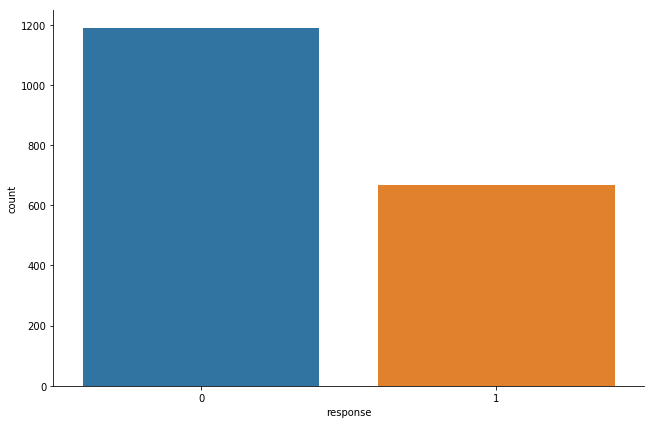

In [12]:
sns.factorplot(x="response", data=df, kind="count", height=6, aspect=1.5);

Response variable is not imbalanced.

In [13]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, review):
        return len(re.findall(pattern, review))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))

        df = pd.DataFrame({'count_words': count_words
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                          })
        
        return df

In [14]:
tc = TextCounts()
df_eda = tc.fit_transform(df.reviewText)

In [15]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('response')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='response', size=5, hue='response')
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

In [16]:
# Add response to df_eda
df_eda['response'] = df.response

# EDA looking at distribution of word counts, capital word counts, and exclamation/question marks

Descriptive stats for count_words
---------------------------------
           count       mean        std  min   25%   50%   75%    max
response                                                            
0         1190.0  57.689916  43.815795  1.0  27.0  48.0  74.0  340.0
1          669.0  75.753363  47.620102  1.0  44.0  67.0  95.0  397.0


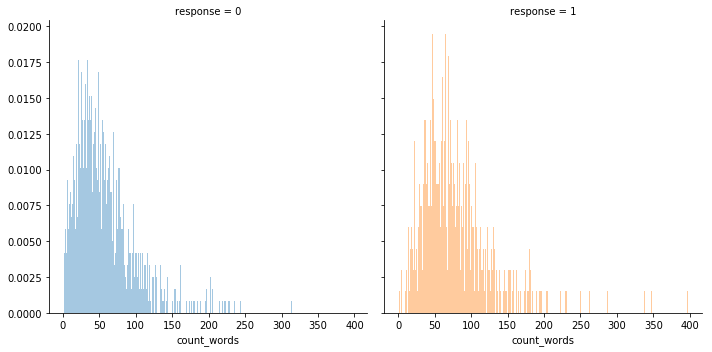

In [17]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_capital_words
-----------------------------------------
           count      mean       std  min  25%  50%  75%   max
response                                                      
0         1190.0  0.300000  1.977140  0.0  0.0  0.0  0.0  63.0
1          669.0  0.216741  0.676346  0.0  0.0  0.0  0.0   9.0


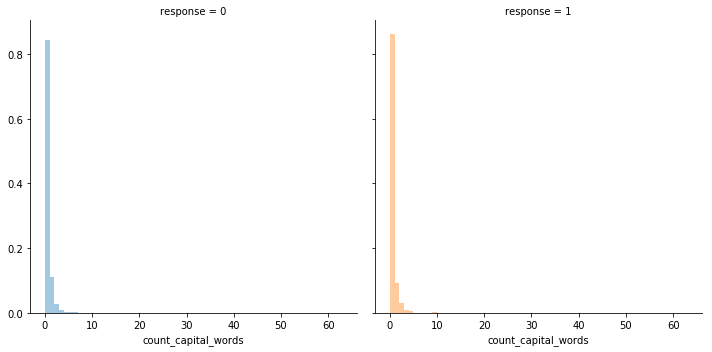

In [18]:
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
           count      mean       std  min  25%  50%  75%   max
response                                                      
0         1190.0  0.563866  1.099218  0.0  0.0  0.0  1.0   9.0
1          669.0  0.343797  1.027268  0.0  0.0  0.0  0.0  18.0


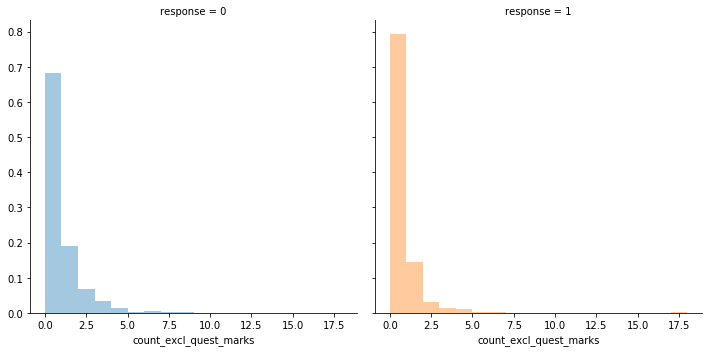

In [19]:
show_dist(df_eda, 'count_excl_quest_marks')

In [20]:
prodType = df.groupby('productType')['product'].count().reset_index().sort_values('product', ascending=False).reset_index(drop=True)
prodType = prodType.rename(columns={'productType':'Product Type', 'product':'Total Reviews'})

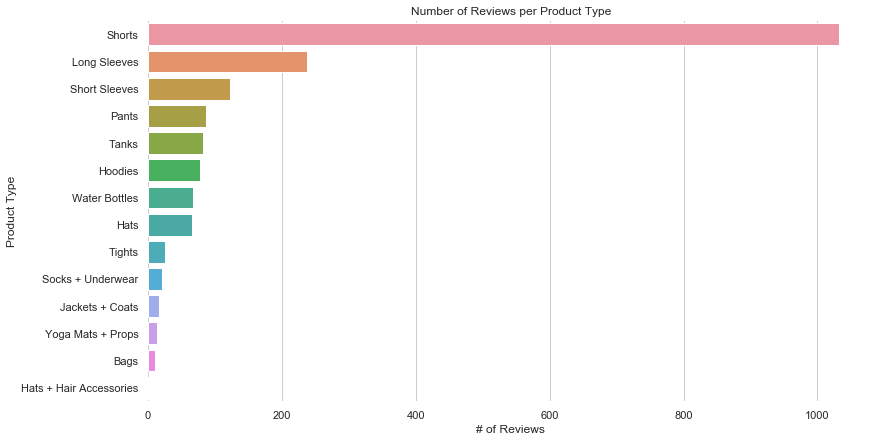

In [21]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the total reviews per category type
sns.set_color_codes("pastel")
sns.barplot(x = 'Total Reviews', y='Product Type', data=prodType)

# Add an informative axis label
ax.set(ylabel="Product Type", title='Number of Reviews per Product Type',
       xlabel="# of Reviews")
sns.despine(left=True, bottom=True)
# plt.savefig('output.png', dpi=300)

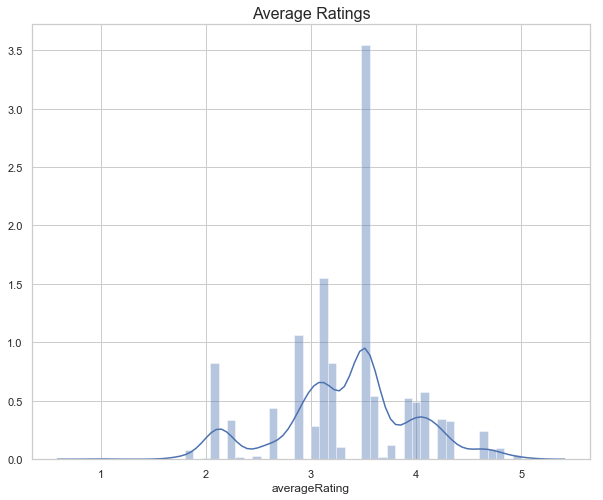

In [22]:
plt.figure(figsize=(10,8))

sns.distplot(df['averageRating'])
plt.title("Average Ratings", fontsize=16)
plt.show();

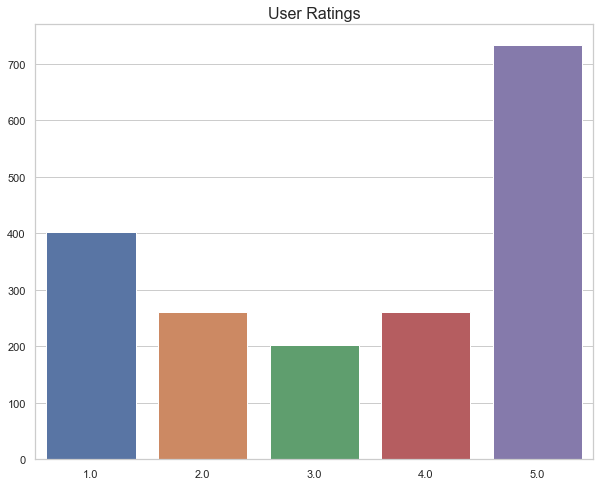

In [23]:
userRatingsCounts = df['userRating'].value_counts()
plt.figure(figsize=(10,8))
sns.barplot(x=userRatingsCounts.index[::-1], y=userRatingsCounts.values[::-1])
plt.title("User Ratings", fontsize=16)
plt.show();

The most amount of responses come from ratings of 1-3; 4's and 5's get the lowest amount of responses.

# Age Range

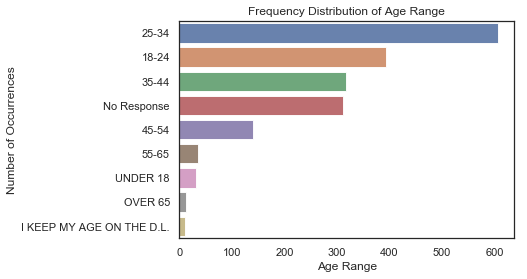

In [24]:
age_count = df['ageRange'].value_counts()
sns.set(style="white")
sns.set_color_codes("pastel")


sns.barplot(y = age_count.index, x = age_count.values, alpha=0.9)

plt.title('Frequency Distribution of Age Range')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Age Range', fontsize=12);

Seems that ratings follow a similar distribution in review length.
There also seems to be a lower amount of 3 and 4 ratings
Mostly ratings of 5

# Date of Review

In [25]:
from datetime import datetime

In [26]:
# By Year

df['reviewDate'] = pd.to_datetime(df['reviewDate'], infer_datetime_format=True)
df['responseDate'] = pd.to_datetime(df['responseDate'], infer_datetime_format=True)
df['reviewYear'], df['reviewMonth'] = df['reviewDate'].dt.year, df['reviewDate'].dt.month
year_counts = df.groupby('reviewYear')['product'].count().reset_index()
year_counts = year_counts.rename(columns={'reviewYear':'Year', 'product':'Total Reviews'})

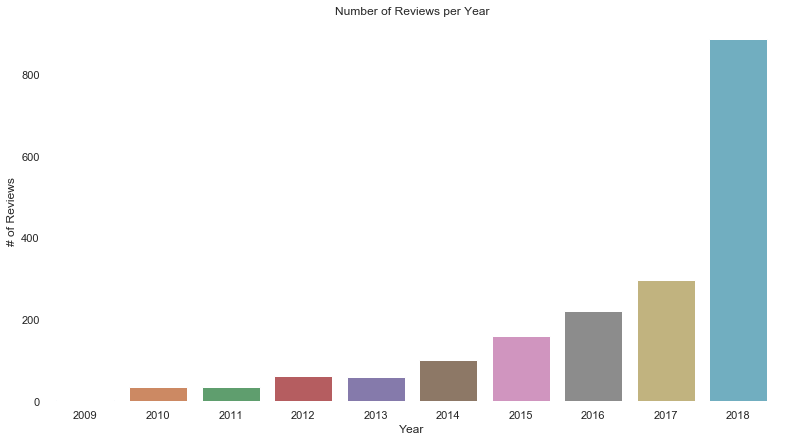

In [27]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the total reviews per category type
sns.set_color_codes("pastel")
sns.barplot(x = 'Year', y='Total Reviews', data=year_counts)

# Add an informative axis label
ax.set(ylabel="# of Reviews", title='Number of Reviews per Year',
       xlabel="Year")
sns.despine(left=True, bottom=True)

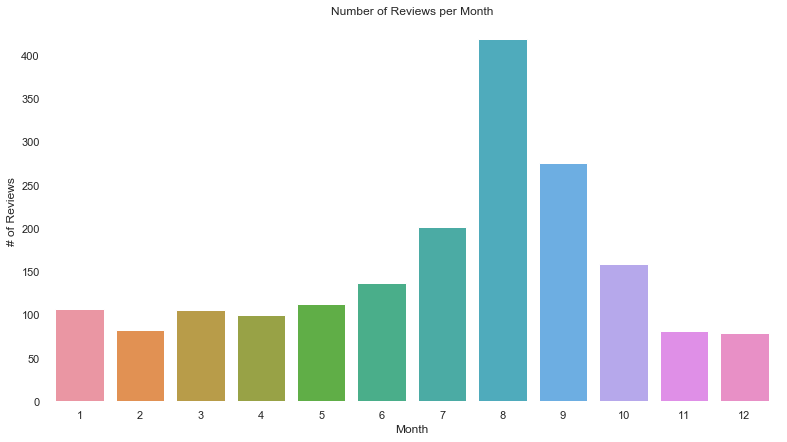

In [28]:
# By Month

month_counts = df.groupby('reviewMonth')['product'].count().reset_index()
month_counts = month_counts.rename(columns={'product':'Total Reviews'})

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the total reviews per category type
sns.set_color_codes("pastel")
sns.barplot(x = 'reviewMonth', y='Total Reviews', data=month_counts)

# Add an informative axis label
ax.set(ylabel="# of Reviews", title='Number of Reviews per Month',
       xlabel="Month")
sns.despine(left=True, bottom=True)

# Responses

In [29]:
df.response.value_counts(normalize=True)

0    0.640129
1    0.359871
Name: response, dtype: float64

# Analysis on Reviews
- preprocess
 - punctuation
 - digits
 - lower case
 - filter stop words
 - stemming (Porter Stemmer)
- clean text
- check for reviews left with no words (there were none)
- count word frequency
# Modeling
- use gridsearch for best parameter using MultinomialNB/Logisitic Regression each using Count Vectorize/TF-IDF for vocabulary
- apply gensim Word2Vec using only Logistic Regression

In [30]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [31]:
ct = CleanText()
sr_clean = ct.fit_transform(df.reviewText)
sr_clean.sample(5)

1787    shirt awesom fit long enough bodi ride squat deadlift pull up exercis also look realli good easi...
724     bought five shirt instructor program littl bit short hope wash stretch bit length past length al...
1140                                                              issu liner rip report lululemon took care
41      bought short incognito camo red multi today eye color saw sale local store way pick store hem me...
148     never purchas workout short liner bit skeptic favorit short wear gym appar minor like liner mayb...
Name: reviewText, dtype: object

In [32]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

0 records have no words left after text cleaning


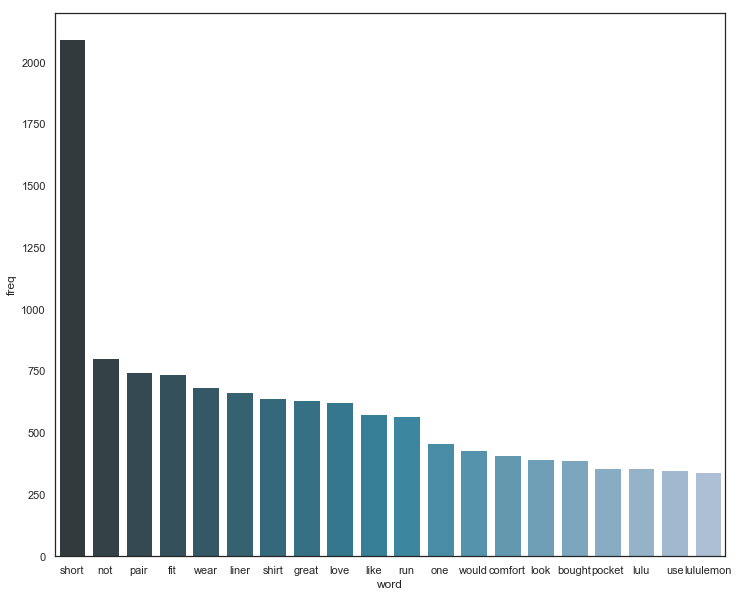

In [33]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [34]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_capital_words',
 'count_excl_quest_marks',
 'response',
 'clean_text']

In [35]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('response', axis=1), df_model['response'], test_size=0.3, random_state=1)

In [37]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words', 'count_excl_quest_marks', 'count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [38]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

# Classifiers

In [39]:
mnb = MultinomialNB()
logreg = LogisticRegression()

# Count Vectorizer

In [40]:
countvect = CountVectorizer()

In [41]:
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   20.5s finished


done in 20.830s

Best CV score: 0.826
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.806


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       362
           1       0.73      0.71      0.72       196

   micro avg       0.81      0.81      0.81       558
   macro avg       0.79      0.79      0.79       558
weighted avg       0.81      0.81      0.81       558



In [42]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   36.0s finished


done in 36.857s

Best CV score: 0.812
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.771


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       362
           1       0.73      0.55      0.63       196

   micro avg       0.77      0.77      0.77       558
   macro avg       0.76      0.72      0.73       558
weighted avg       0.77      0.77      0.76       558



# TF-IDF

In [43]:
tfidfvect = TfidfVectorizer()

In [44]:
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   17.0s finished


done in 17.373s

Best CV score: 0.812
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.787


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       362
           1       0.74      0.61      0.67       196

   micro avg       0.79      0.79      0.79       558
   macro avg       0.77      0.75      0.76       558
weighted avg       0.78      0.79      0.78       558



In [45]:
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   34.4s finished


done in 34.462s

Best CV score: 0.804
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.772


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       362
           1       0.76      0.52      0.61       196

   micro avg       0.77      0.77      0.77       558
   macro avg       0.77      0.71      0.73       558
weighted avg       0.77      0.77      0.76       558



# Word2Vec: word similarity

In [46]:
SIZE = 50

X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))

model = gensim.models.Word2Vec(X_train.clean_text_wordlist
                 , min_count=1
                 , size=SIZE
                 , window=5
                 , workers=4)

In [54]:
model.most_similar('bad', topn=5)

[('lulu', 0.9998579025268555),
 ('like', 0.9998578429222107),
 ('loos', 0.9998472332954407),
 ('seem', 0.9998403191566467),
 ('pull', 0.9998385310173035)]

In [55]:
def compute_avg_w2v_vector(w2v_dict, review):
    list_of_word_vectors = [w2v_dict[w] for w in review if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result

In [56]:
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [57]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)

# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [58]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)
#joblib.dump(best_logreg_w2v, '../output/best_logreg_w2v.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


done in 2.701s

Best CV score: 0.643
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l1'
Test score with best_estimator_: 0.647


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.66      0.92      0.77       362
           1       0.49      0.14      0.22       196

   micro avg       0.65      0.65      0.65       558
   macro avg       0.58      0.53      0.49       558
weighted avg       0.60      0.65      0.58       558



[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.7s finished


# Best model - MultinomialNB using features from CountVectorizer():
Parameters:
* clf__alpha: 0.75
* features__pipe__vect__max_df: 0.75
* features__pipe__vect__min_df: 2
* features__pipe__vect__ngram_range: (1, 1)

Error Metrics:


In [59]:
textcountscols = ['count_capital_words', 'count_excl_quest_marks', 'count_words']
    
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                         , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                              , ('vect', CountVectorizer(max_df=0.75, min_df=2, ngram_range=(1,2)))]))]
                       , n_jobs=-1)

pipeline = Pipeline([
    ('features', features)
    , ('clf', MultinomialNB(0.75))
])

best_model = pipeline.fit(df_model.drop('response', axis=1), df_model.response)

# New Reviews with a Response

In [60]:
new_review_response = pd.Series(['I am a disappointed with this shirt compared to my past Metal Vent Tech shirts. \
                                  The fabric is thin and the cut of the shirt does not feel like the Lululemon I know. \
                                  The shirt still wicks sweat well but does not live up to my past experiences.',
                                  'First time the fabric will show damages after wearing the shirt for the first time. \
                                  I really like the shirt and the color... Not sure about the quality, as this is the first time I face such issue.',
                                  "Bummed, I bought this shirt in Maroon/Blackish color about a month ago and it's already in rough shape \
                                  for the price that I paid for it. It already has a small hole and it looks like the metal fibers in the shirt are pulling out.",
                                 'This is a review of specifically the Black/Cloud Blue color of the Metal Vent Tech shirts. \
                                 I own several MVT’s in other colors and they’re great shirts but the fabric of this one is different. \
                                 Got a pick in the front in the first hour of wearing the shirt. Have NEVER had this happen before.'
                                 ])
df_counts_pos = tc.transform(new_review_response)
df_clean_pos = ct.transform(new_review_response)
df_model_pos = df_counts_pos
df_model_pos['clean_text'] = df_clean_pos

best_model.predict(df_model_pos).tolist()

[1, 1, 1, 1]

# New Reviews without a Response

In [61]:
new_review_noResponse = pd.Series(["Love the feel and material of all the Metal vent tech. Sometimes the fit isn't perfect for every body style.\
                                    Can be a little wide in the mid-section for an athletic fit if you size up for your shoulder's/arms. \
                                    Otherwise the wear and material and second to none. These shirts last forever if you treat them as instructed by Lululemon.",
                                  "Love the newer spring colors but the sizing on these shirts are so inconsistent.\
                                  For me, the chest and forearm area are way too tight. I need a little room to breathe! \
                                  If those issues were resolved this would be perfect.",
                                  "Lulu just isn't the company that it used to be. When ordering this shirt I thought it would be a little lighter than it appears online. \
                                  All of the color options are poor and the fit, fabrics and and stitching have all been cheapened over the years.",
                                  "I had this shirt for a year. the fabric gets thinner and thinner eventually leading to runs and holes. \
                                  I had this shirt custom screen printed for a school athletic team with my initials and team name on it. \
                                  we had won state races and championships showing up in this shirt. \
                                  after sending in pictures of the holes in the shirt, lulu stated I had to send it for them to actually do anything about it, \
                                  but the shirt has too much sentimental value. ill just throw in the back of my closet and stay away from these shirts, you should too"])

df_counts_neg = tc.transform(new_review_noResponse)
df_clean_neg = ct.transform(new_review_noResponse)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg

best_model.predict(df_model_neg).tolist()

[0, 0, 0, 0]

# Next steps:
- Scrape new reviews and predict responses (or not)!
- Use other features, e.g. user rating, price, product (do certain products have a higher priority?)